# Testing the performance of CNNs on different flood images, cloud cover %

In [1]:
# import ee
from IPython import display
# import math
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
# from osgeo import gdal
# import tempfile
import tensorflow as tf
# import urllib
import rasterio
from zipfile import *
import math
from math import sqrt
import sklearn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, accuracy_score
import time


### Training the CNN on an image with 10-90% cloud cover.

In [2]:
import os

path = 'C:/Users/ipdavies/CPR/data/'

# Get list of all images
img_list = []
for file in os.listdir(path):
        img_list.append(file)

print(img_list)

img = '4337_LC08_026038_20160325_1'

['.ipynb_checkpoints', 'cloudmasks', 'images', 'models', 'tables']


In [3]:
# Reorders the tifs (i.e. individual bands) downloaded from GEE according to feature order in feat_list_new,
# then stacks them all into one multiband image called 'stack.tif' located in input path
# Reqs: rasterio, os, from zipfile import *
# Ideally want to have this function in another notebook and call it, but running into problems - ZipFile not found
# from ipynb.fs.full.useful_funcs import tifStacker

def tifStacker(path, img, feat_list_new): 

    file_list = []
    path = path+'images/'+img
    
    # This gets the name of all files in the zip folder, and formats them into a full path readable by rasterio.open()
    with ZipFile(path + '/' + img + '.zip', 'r') as f:
        names = f.namelist()
        names = ['zip://'+ path + '/' + img + '.zip!' +name for name in names]
        for file in names:
            if file.endswith('.tif'):
                file_list.append(file)
    
    feat_list_files = list(map(lambda x: x.split('.')[-2], file_list)) # Grabs a list of features in file order        
    
    # Create 1 row df of file names where each col is a feature name, in the order files are stored locally
    file_arr = pd.DataFrame(data=[file_list], columns=feat_list_files)

    # Then index the file list by the ordered list of feature names used in training
    file_arr = file_arr.loc[:, feat_list_new]

    # The take this re-ordered row as a list - the new file_list
    file_list = list(file_arr.iloc[0,:])
    
    # Read metadata of first file. This needs to be a band in float32 dtype, because it sets the metadata for the entire stack
    # and we are converting the other bands to float64
    with rasterio.open(file_list[1]) as src0:
        meta = src0.meta
        meta['dtype'] = 'float32'
    #         print(meta)

    # Update meta to reflect the number of layers
    meta.update(count = len(file_list))

    # Read each layer, convert to float, and write it to stack
    # There's also a gdal way to do this, but unsure how to convert to float: https://gis.stackexchange.com/questions/223910/using-rasterio-or-gdal-to-stack-multiple-bands-without-using-subprocess-commands

    # Make new directory for stacked tif if it doesn't already exist
    try:
        os.mkdir(path +'/stack')
    except FileExistsError:
        print('Stack directory already exists')

    # Remove stack file if already exists
    try:
        os.remove(path + '/stack/stack.tif')
        print('Removing existing "stack.tif" and creating new one')
    except FileNotFoundError:
    #     pass
        print('Creating "stack.tif"')

    with rasterio.open(path + '/stack/stack.tif', 'w', **meta) as dst:
        for id, layer in enumerate(file_list, start=0):
            with rasterio.open(layer) as src1:
                dst.write_band(id+1, src1.read(1).astype('float32'))
    
    return feat_list_files

This loads the stacked image and masks it 9 times for cloud cover 10-90%, resulting in 9 arrays and 9 tuples of row, col indices of the array cells with non-nan values. It might take too much memory to have all 9 arrays loaded though ...

In [4]:
def preprocessing(path, img, pctl):

    # Get local image
    with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
        data = ds.read()
        data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)
    
    # load cloudmasks
    cloudMaskDir = path+'cloudmasks/'+img
    
    cloudMask = np.load(cloudMaskDir+'/'+img+'_clouds_'+str(pctl)+'.npy')
    
    # Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN
    data[cloudMask] = -999999
    
    # Convert -999999 to None
    data[data == -999999] = np.nan

    # Get indices of non-nan values. These are the indices of the original image array
    data_ind = np.where(~np.isnan(data[:,:,1]))
        
    return data, data_ind

In [5]:
def trainVal(data):
    
    HOLDOUT_FRACTION = 0.1

    # Reshape into a single vector of pixels.
    data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

    # Remove NaNs
    data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]
    data_vector.shape

    # Select only the valid data and shuffle it.
    # valid_data = data_vector[numpy.equal(data_vector[:,8], 1)]
    # np.random.shuffle(data_vector)

    # Hold out a fraction of the labeled data for validation.
    training_size = int(data_vector.shape[0] * (1 - HOLDOUT_FRACTION))
    training_data = data_vector[0:training_size,:]
    validation_data = data_vector[training_size:-1,:]

    # Compute per-band means and standard deviations of the input bands.
    data_mean = training_data[:,0:14].mean(0)
    data_std = training_data[:,0:14].std(0)
    
    return [data_vector, training_data, validation_data, data_mean, data_std, training_size]

Function to train CNN on image, save model, and return performance metrics

In [6]:
# CNN layer builder
def make_nn_layer(input, output_size):
    input_size = input.get_shape().as_list()[1]
    weights = tf.Variable(tf.truncated_normal(
        [input_size, output_size],
        stddev=1.0 / math.sqrt(float(input_size))))
    biases = tf.Variable(tf.zeros([output_size]))
    return tf.matmul(input, weights) + biases


In [7]:
def CNNtrainer(data_vector, training_data, validation_data, data_mean, data_std, model_path, img, pctl):

    model_path = model_path+img+'_clouds_'+str(pctl)
    model_name = img+'_clouds_'+str(pctl)
    checkpoint_filename = model_name+'_checkpoint'
    
    # Make a new directory for the model
    try:
        os.mkdir(model_path)
    except FileExistsError:
        print('Model directory already exists')
        
#     tf.reset_default_graph()
    
    import time
    def timer(start,end):
        hours, rem = divmod(end-start, 3600)
        minutes, seconds = divmod(rem, 60)
        return str("{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

    # Had to alter some config and runoptions because kept running into OOM at last step during eval 
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )
    config.gpu_options.allow_growth = True
    run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

    flooded = feat_list_files.index('flooded')
    
    # ------------------------------------------------------------------------------------------------
    NUM_INPUT_BANDS = 14
    NUM_HIDDEN_1 = 15
    NUM_HIDDEN_2 = 15
    NUM_CLASSES = 2
    BATCH_SIZE = 1000
    NUM_BATCHES = 1000

    input = tf.placeholder(tf.float32, shape=[None, NUM_INPUT_BANDS], name='input')
    labels = tf.placeholder(tf.float32, shape=[None], name='labels')

    normalized = (input - data_mean) / data_std
    hidden1 = tf.nn.tanh(make_nn_layer(normalized, NUM_HIDDEN_1), name='hidden1')
    hidden2 = tf.nn.tanh(make_nn_layer(hidden1, NUM_HIDDEN_2), name='hidden2')
    logits = make_nn_layer(hidden2, NUM_CLASSES)
    outputs = tf.argmax(logits, 1, name='outputs')

    int_labels = tf.to_int64(labels)
    cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits = logits, labels = int_labels, name='xentropy')
    train_step = tf.train.AdamOptimizer().minimize(cross_entropy) # should we minimize something else?

    correct_prediction = tf.equal(outputs, int_labels, name='correct_prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    # ------------------------------------------------------------------------------------------------
    
    mySaver = tf.train.Saver(save_relative_paths=True)
    init_op = tf.global_variables_initializer()
    start_time = time.time()
    
    with tf.Session(config=config) as sess:
        
        sess.run(init_op, options=run_options)

        training_dict = {
            input: training_data[:,0:14],
            labels: training_data[:,14],
        }

        validation_dict = {
            input: validation_data[:,0:14],
            labels: validation_data[:,14],
        }

        for i in range(NUM_BATCHES):
            batch = training_data[np.random.choice(training_size, BATCH_SIZE, False),:]
            train_step.run({input: batch[:,0:14], labels: batch[:,14]})

            if i % 100 == 0 or i == NUM_BATCHES - 1:
    #             print('Train acc. %.2f%%, val acc. %.2f%%, train recall %.2f%, val recall %.2f%, train precision %.2f%, val precision %.2f%, at step %d' 
                print('Train acc. %.2f%%, val acc. %.2f%%, at step %d' 
                      % (accuracy.eval(training_dict) * 100,
                         accuracy.eval(validation_dict) * 100, 
                         i))
                
        output_data = outputs.eval({input: data_vector[:,0:14]})

        # Save the model
        mySaver.save(sess, model_path+'/'+model_name+'.ckpt', 
                    global_step = NUM_BATCHES)
#                     latest_filename=checkpoint_filename)

    print('CNN training runtime for ' + str(pctl) + '% cloud cover: ' + timer(start_time, time.time()))
    
    return output_data


In [8]:
# Loop to do all the functions together

path = 'C:/Users/ipdavies/CPR/data/'
feat_list_new = ['aspect','curve', 'developed', 'distExtent', 'elevation', 'forest',
 'GSW_maxExtent', 'hand', 'other_landcover', 'planted', 'slope', 'spi', 'twi', 'wetlands', 'flooded']
model_path = path+'models/cnn_vary_clouds/'
img = '4337_LC08_026038_20160325_1'
pctls = [10,20,30,40,50,60,70,80,90]

#  Stack all the flood imagery
feat_list_files = tifStacker(path, img, feat_list_new)

precision = []
recall = []
f1 = []
accuracy = []
times = []

# Load stacked image, preprocess
for i, pctl in enumerate(pctls):
    
    data, data_ind = preprocessing(path, img, pctl)
    
    data_vector, training_data, validation_data, data_mean, data_std, training_size = trainVal(data)
    
    start_time = time.time() # Start timer for CNN training
    
    y_pred = CNNtrainer(data_vector, training_data, validation_data, data_mean, data_std, model_path, img, pctl)
    
    times.append(time.time() - start_time) # Elapsed time in seconds
    
    y_true = data_vector[:,14]
    
    precision.append(sklearn.metrics.precision_score(y_true, y_pred))
    recall.append(sklearn.metrics.recall_score(y_true, y_pred))
    f1.append(sklearn.metrics.f1_score(y_true, y_pred))
    accuracy.append(sklearn.metrics.accuracy_score(y_true, y_pred))
    
metrics = pd.DataFrame(np.column_stack([pctls, accuracy, precision, recall, f1, times]),
                      columns=['cloud_cover','accuracy','precision','recall','f1', 'time'])

print(metrics)
    

Stack directory already exists
Removing existing "stack.tif" and creating new one


C:\Users\ipdavies\AppData\Local\Continuum\miniconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


Train acc. 48.67%, val acc. 49.60%, at step 0
Train acc. 97.38%, val acc. 98.38%, at step 100
Train acc. 98.37%, val acc. 99.00%, at step 200
Train acc. 98.74%, val acc. 99.32%, at step 300
Train acc. 98.89%, val acc. 99.41%, at step 400
Train acc. 98.88%, val acc. 99.39%, at step 500
Train acc. 98.91%, val acc. 99.42%, at step 600
Train acc. 98.92%, val acc. 99.43%, at step 700
Train acc. 98.94%, val acc. 99.45%, at step 800
Train acc. 98.94%, val acc. 99.44%, at step 900
Train acc. 98.95%, val acc. 99.45%, at step 999
CNN training runtime for 10% cloud cover: 00:21:08.50
Train acc. 41.95%, val acc. 34.33%, at step 0
Train acc. 98.06%, val acc. 98.83%, at step 100
Train acc. 98.75%, val acc. 99.33%, at step 200
Train acc. 98.89%, val acc. 99.42%, at step 300
Train acc. 98.92%, val acc. 99.41%, at step 400
Train acc. 98.93%, val acc. 99.42%, at step 500
Train acc. 98.95%, val acc. 99.44%, at step 600
Train acc. 98.95%, val acc. 99.44%, at step 700
Train acc. 98.96%, val acc. 99.45%, at

Need to add a printout or metric with how many flooded pixels are in train/test dataset.

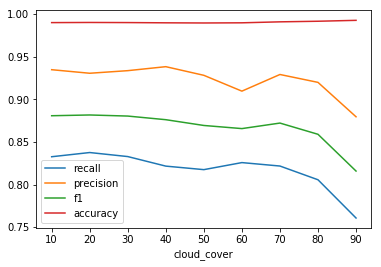

In [9]:
metrics.to_csv(path+'tables/CNN_cloud_metrics/'+'train_'+img+'.csv', index=False)

# Visualize training metrics

metrics = pd.read_csv(path+'tables/CNN_cloud_metrics/'+'train_'+img+'.csv')
metrics.plot(x='cloud_cover', y=['recall', 'precision','f1','accuracy'])

### Predict on cloud gaps

In [11]:
def preprocessing_gaps(path, img, pctl):

    # Get local image
    with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
        data = ds.read()
        data = data.transpose((1, -1, 0)) # Not sure why the rasterio.read output is originally (D, W, H)
    
    # load cloudmasks
    cloudMaskDir = path+'cloudmasks/'+img
    
    cloudMask = np.load(cloudMaskDir+'/'+img+'_clouds_'+str(pctl)+'.npy')
    
    # Invert cloudmask to get the gaps
    cloudMask = np.invert(cloudMask)
    
    # Need to remove NaNs because any arithmetic operation involving an NaN will result in NaN
    data[cloudMask] = -999999
    
    # Convert -999999 to None
    data[data == -999999] = np.nan

    # Get indices of non-nan values. These are the indices of the original image array
    data_ind = np.where(~np.isnan(data[:,:,1]))
    
    # Reshape into a single vector of pixels.
    data_vector = data.reshape([data.shape[0] * data.shape[1], data.shape[2]])

    # Remove NaNs
    data_vector = data_vector[~np.isnan(data_vector).any(axis=1)]

    # Compute per-band means and standard deviations of the input bands.
    data_mean = data_vector[:,0:14].mean(0)
    data_std = data_vector[:,0:14].std(0)

    return data_vector, data_mean, data_std, data_ind

Problem: TF doesn't save every variable, like outputs or input, so we need to save those somehow
https://stackoverflow.com/questions/43887425/how-to-import-a-model-in-tensorflow

In [31]:
def gapFill(data_vector, data_mean, data_std, img, pctl, model_path):
    
    tf.reset_default_graph()
    
    model_path = model_path+img+'_clouds_'+str(pctl)
    model_name = img+'_clouds_'+str(pctl)
    checkpoint_filename = model_name+'_checkpoint'
    
    # Had to alter some config and runoptions because kept running into OOM at last step during eval 
    config = tf.ConfigProto(
        device_count = {'GPU': 0}
    )

    config.gpu_options.allow_growth = True
    run_options=tf.RunOptions(report_tensor_allocations_upon_oom=True)

    with tf.Session(config=config) as sess:
#     with tf.Session() as sess:
        mySaver = tf.train.import_meta_graph(model_path+'/'+model_name+'.ckpt-1000.meta') # Get metadata of saved graph
        mySaver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir=model_path+'./')) # Restore checkpoint
        graph = tf.get_default_graph()
        input = graph.get_tensor_by_name("input:0") # Get inputs placeholder
        labels = graph.get_tensor_by_name("labels:0") # Get inputs placeholder
        outputs = graph.get_tensor_by_name('outputs:0') # Get outputs
        hidden1 = graph.get_tensor_by_name('hidden1:0')
        hidden2 = graph.get_tensor_by_name('hidden2:0')
#         cross_entropy = graph.get_operation_by_name('xentropy:0')
        tf.global_variables_initializer()

        
        
        y_pred = outputs.eval({input: data_vector[:,0:14]})

    return y_pred

In [32]:
model_path = path+'models/cnn_vary_clouds/'
pctls = [10,20,30,40,50,60,70,80,90]
img = '4337_LC08_026038_20160325_1'
pctls = [10,20,30,40,50,60,70,80,90]
import math

accuracy = []
predictions = []

precision = []
recall = []
f1 = []

precision_w = []
recall_w = []
f1_w = []

for i, pctl in enumerate(pctls):
    
    data_vector, data_mean, data_std, data_ind = preprocessing_gaps(path, img, pctl)
    
    y_pred = gapFill(data_vector, data_mean, data_std, img, pctl, model_path)
    
    y_true = data_vector[:,14]
    
    accuracy.append(sklearn.metrics.accuracy_score(y_true, y_pred))
    
    precision.append(sklearn.metrics.precision_score(y_true, y_pred))
    recall.append(sklearn.metrics.recall_score(y_true, y_pred))
    f1.append(sklearn.metrics.f1_score(y_true, y_pred))
    
    precision_w.append(sklearn.metrics.precision_score(y_true, y_pred, average='weighted'))
    recall_w.append(sklearn.metrics.recall_score(y_true, y_pred, average='weighted'))
    f1_w.append(sklearn.metrics.f1_score(y_true, y_pred, average='weighted'))
    
    predictions.append(y_pred)

INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_10./4337_LC08_026038_20160325_1_clouds_10.ckpt-1000
INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_20./4337_LC08_026038_20160325_1_clouds_20.ckpt-1000
INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_30./4337_LC08_026038_20160325_1_clouds_30.ckpt-1000
INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_40./4337_LC08_026038_20160325_1_clouds_40.ckpt-1000
INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026038_20160325_1_clouds_50./4337_LC08_026038_20160325_1_clouds_50.ckpt-1000
INFO:tensorflow:Restoring parameters from C:/Users/ipdavies/CPR/data/models/cnn_vary_clouds/4337_LC08_026

In [ ]:
data_vector, data_mean, data_std, data_ind = preprocessing_gaps(path, img, pctl)
predictions[0] == data_vector

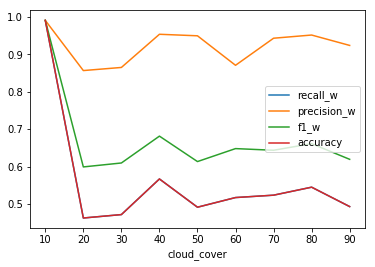

In [34]:
gap_metrics_w = pd.DataFrame(np.column_stack([pctls, accuracy, precision_w, recall_w, f1_w]),
                      columns=['cloud_cover','accuracy','precision_w','recall_w','f1_w'])

gap_metrics_w.plot(x='cloud_cover', y=['recall_w', 'precision_w','f1_w','accuracy'])

# gap_metrics.to_csv(path+'tables/CNN_cloud_metrics/'+'gap_'+img+'.csv', index=False)

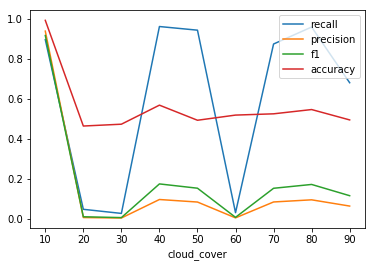

In [33]:
gap_metrics = pd.DataFrame(np.column_stack([pctls, accuracy, precision, recall, f1]),
                      columns=['cloud_cover','accuracy','precision','recall','f1'])

gap_metrics.plot(x='cloud_cover', y=['recall', 'precision','f1','accuracy'])

# gap_metrics.to_csv(path+'tables/CNN_cloud_metrics/'+'gap_'+img+'.csv', index=False)

Why do the metrics not decline linearly?
 - Not enough flooded pixels in training set

Test metrics vs ...
- Number of flooded pixels in training / number of flooded pixels in image
 

### Plot filled gaps

First create binary correct/incorrect prediction image

In [115]:
model_path = path+'models/cnn_vary_clouds/'
img = '4337_LC08_026038_20160325_1'
pctls = [10,20,30,40,50,60,70,80,90]

flooded_imgs = []
prediction_imgs = []

# Reshape predicted values back into image band
with rasterio.open(path + 'images/'+ img + '/stack/stack.tif', 'r') as ds:
        shape = ds.read(1).shape # Shape of full original image
        arr_empty = np.zeros(shape) # Create empty array with this shape
        arr_empty[:] = np.nan # Convert all zeroes to NaN
            
for i, pctl in enumerate(pctls):
    data_vector, data_mean, data_std, data_ind = preprocessing_gaps(path, img, pctl)

    # Add predicted values to cloud-covered pixel positions
    prediction_img = arr_empty
    rows, cols = zip(data_ind)
    prediction_img[rows, cols] = predictions[i]
    prediction_imgs.append(prediction_img)
    
    # Add actual flood values to cloud-covered pixel positions
    flooded_img = arr_empty
    flooded_img[rows, cols] = data_vector[:,14]
    flooded_imgs.append(flooded_img)

In [116]:
flooded_imgs == prediction_imgs

True

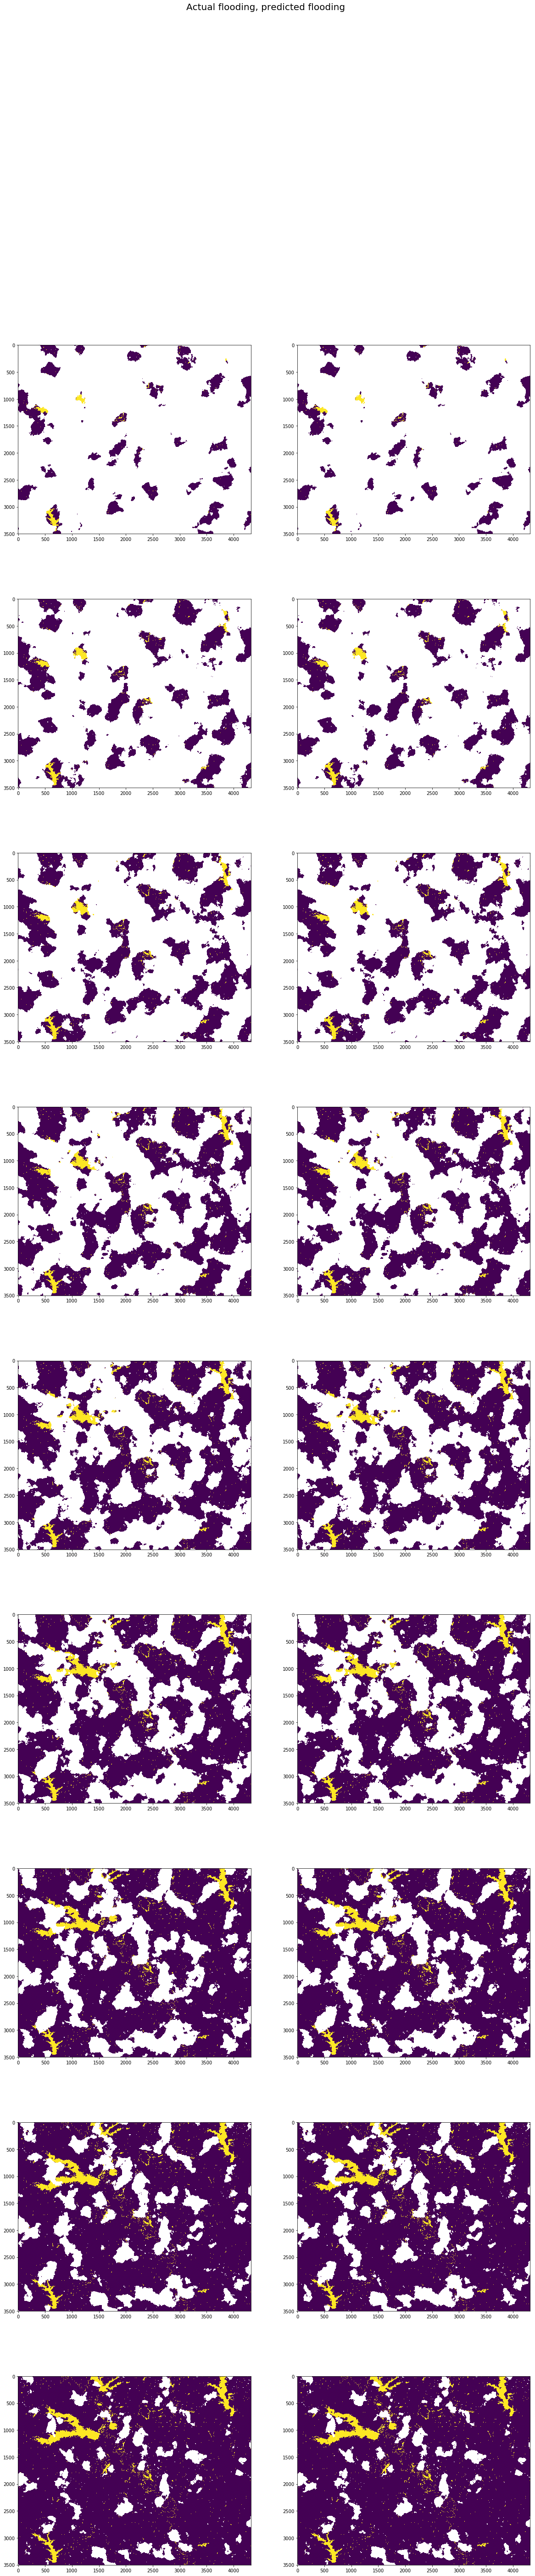

In [117]:
plt.figure(figsize=(20,100))
columns = 2

images = []

for i in range(len(flooded_imgs)):
    images.append(flooded_imgs[i])
    images.append(prediction_imgs[i])

for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.suptitle('Actual flooding, predicted flooding', fontsize=20)
    plt.imshow(image)
    plt.colorbar